In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
from anndata import AnnData
import sys
sys.path.append('F:/HLL/SpatialCell')
from SpatialCell.plot import stack_plot
import random
random.seed(42)

sys.path.append('F:/HLL/SpatialCell/SpatialCell')

In [2]:
adata = sc.read_h5ad('F:/HLL/SpatialCell/data/shaped.h5ad')

In [4]:
# 计算每个三角形的边长
def calculate_edge_lengths(triangles, points):
    edges = []
    for triangle in triangles:
        # 获取三角形的三个顶点坐标
        p1, p2, p3 = points[triangle]
        # 计算三条边的长度
        edge_lengths = [
            np.linalg.norm(p1 - p2),
            np.linalg.norm(p2 - p3),
            np.linalg.norm(p3 - p1)
        ]
        edges.append(edge_lengths)
    return np.array(edges)

# 计算每个三角形的面积（使用海伦公式）
def calculate_triangle_area(triangle, points):
    p1, p2, p3 = points[triangle]
    # 三个边长
    a = np.linalg.norm(p1 - p2)
    b = np.linalg.norm(p2 - p3)
    c = np.linalg.norm(p3 - p1)
    # 半周长
    s = (a + b + c) / 2
    # 海伦公式计算面积
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

# 获取每个点的最短边长度和最小面积三角形
def calculate_point_properties(triang, points):
    # 获取所有三角形的边长
    edge_lengths = calculate_edge_lengths(triang.simplices, points)
    
    # 获取所有三角形的面积
    areas = np.array([calculate_triangle_area(triangle, points) for triangle in triang.simplices])
    
    # 初始化数组来存储每个点的最短边长度和最小面积
    min_edge_lengths = np.full(len(points), np.inf)
    min_areas = np.full(len(points), np.inf)
    
    # 对于每个三角形，更新每个点的最短边和最小面积
    for i, triangle in enumerate(triang.simplices):
        # 获取当前三角形的边长和面积
        triangle_edges = edge_lengths[i]
        triangle_area = areas[i]
        
        # 对每个点，更新最短边长度和最小面积
        for point_index,egd_index in zip(triangle,[[0,2],[0,1],[1,2]]):
            min_edge_lengths[point_index] = min(min_edge_lengths[point_index], *triangle_edges[egd_index])
            min_areas[point_index] = min(min_areas[point_index], triangle_area)
    
    return min_edge_lengths, min_areas


In [7]:
from scipy.spatial import Delaunay

tmp = adata[(adata.obs['Image'] == '1932246') & (adata.obs['Parent'] == 'TC5') & (adata.obs['label'] == 'SPON2')]
points = np.array(tmp.obs[['Centroid X µm', 'Centroid Y µm',]])
triang = Delaunay(points)
edges, areas = calculate_point_properties(triang, points)

In [15]:
label = 'label'
target_cell = 'SPON2'
id = 'Image'
result = {}
batch = 'Parent'
x,y = 'Centroid X µm', 'Centroid Y µm'
adata.obs['triang_area'],adata.obs['triang_edges_length'] = np.nan,np.nan
for target_cell in adata.obs[label].unique():
    sub0 = adata[adata.obs[label] == target_cell]
    # Iterate through unique images or regions
    for i in sub0.obs[id].unique():
        sub1 = sub0[sub0.obs[id] == i]
        sub1_result = {}
        if batch is None:  # No batch specified
            points = np.array(sub1.obs[[x, y]])
            triang = Delaunay(points)
            edges, areas = calculate_point_properties(triang, points)
            edges = pd.Series(edges, index=sub1.obs_names)
            areas = pd.Series(areas, index=sub1.obs_names)
            adata.obs.loc[sub1.obs_names, 'triang_area'] = areas
            adata.obs.loc[sub1.obs_names, 'triang_edges_length'] = edges
        else:  # Batch specified
            for j in sub1.obs[batch].unique():
                sub2 = sub1[sub1.obs[batch] == j]
                points = np.array(sub2.obs[[x, y]])
                if points.shape[0] < 3:
                    print(f'Not enough points to calculate triangulation for {target_cell} in {i} {j}')
                    continue
                triang = Delaunay(points)
                edges, areas = calculate_point_properties(triang, points)
                edges = pd.Series(edges, index=sub2.obs_names)
                areas = pd.Series(areas, index=sub2.obs_names)
                adata.obs.loc[sub2.obs_names, 'triang_area'] = areas
                adata.obs.loc[sub2.obs_names, 'triang_edges_length'] = edges
        

Not enough points to calculate triangulation for ZFP36L2 in 2138935-1 TC1


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import pandas as pd

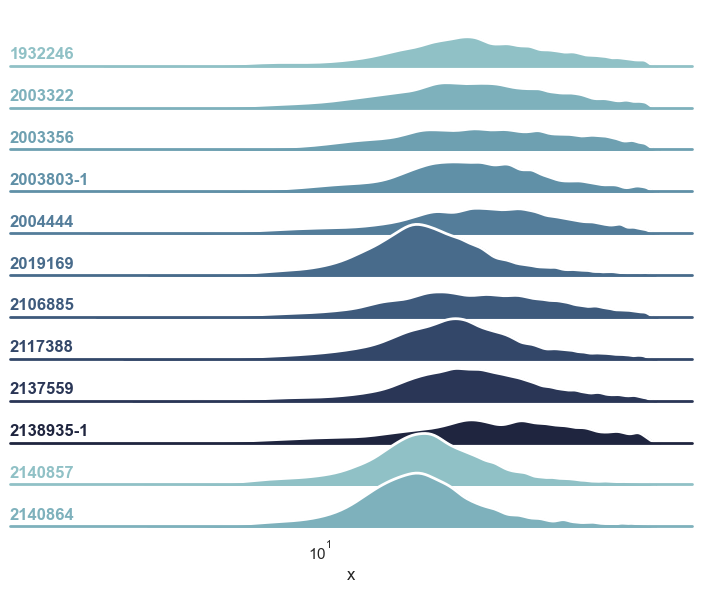

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = adata.obs[['Image','triang_area']]

lower_percentile = df['triang_area'].quantile(0.01)
upper_percentile = df['triang_area'].quantile(0.8)
df = df[(df['triang_area'] >= lower_percentile) & (df['triang_area'] <= upper_percentile)]
df.columns = ['g','x']

# 过滤异常值

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
ax = plt.gca()
ax.set_xscale("log")